# 겨울에 따뜻하면 여름에 폭염이 나타난다.
- made by 임낙현

## 0. 필요한 패키지 및 데이터 불러오기

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

In [2]:
# df = pd.read_csv('output/daegu.csv', encoding = 'cp949')

In [3]:
df_pre = pd.read_csv('output/daegu_pre.csv')
# df_final.head()

## 1. 데이터 확인 및 전처리

### Ⅰ. 결측치 확인

In [4]:
# 상대습도의 결측치인 -1, -50, 0 의 개수들을 세어봄

humidity=df_pre.loc[:,'humidity']

print(humidity.loc[humidity==-1].count())
print(humidity.loc[humidity==-50].count())
print(humidity.loc[humidity==0].count())

30222
0
682


In [5]:
# 온도의 결측치인 -1, -50, 0 의 개수들을 세어봄

temp=df_pre.loc[:,'temp']

print(temp.loc[temp==-1].count())
print(temp.loc[temp==-50].count())
print(temp.loc[temp==0].count())

47171
6062
69673


In [6]:
# 상대습도의 결측치들 -1, -50, 0 을 NaN으로 변경

humidity_1=humidity.replace(-1,np.nan)
humidity_2=humidity_1.replace(-50,np.nan)
humidity_pre=humidity_2.replace(0,np.nan)

print(humidity_pre.loc[humidity==-1].count())
print(humidity_pre.loc[humidity==-50].count())
print(humidity_pre.loc[humidity==0].count())

0
0
0


In [7]:
# 온도의 결측치들 -1, -50 을 NaN으로 변경

temp_1=temp.replace(-1,np.nan)
temp_pre=temp_1.replace(-50,np.nan)

print(temp_pre.loc[temp_pre==-1].count())
print(temp_pre.loc[temp_pre==-50].count())

0
0


### Ⅱ. 결측치가 처리된 데이터프레임을 합침

In [8]:
# 온도와 상대습도 Series들을 합쳐서 데이터프레임으로 만듦
tem_hum=pd.concat([temp_pre,humidity_pre],axis=1)
tem_hum.head()

,temp,humidity
0,16.500000,53.0
1,18.100000,49.0
2,19.700001,46.0
3,20.799999,41.0
4,22.200001,36.0


In [9]:
# 날짜와 지역만 있는 데이터프레임을 만듦
df_nh=df_pre.loc[:,['year','month','day','hour','region']]

# 온도와 상대습도를 합친 데이터프레임과 날짜와 지역이 있는 데이터프레임을 합침
temp_mv=pd.concat([df_nh,tem_hum],axis=1)

# 온도를 소수점 아래 둘째자리에서 반올림 한 것으로 만듦
temp_mv['temp']=round(temp_mv['temp'],2)
temp_mv.head() # 데이터 확인

,year,month,day,hour,region,temp,humidity
0,2010,6,1,0,동인동,16.5,53.0
1,2010,6,1,1,동인동,18.1,49.0
2,2010,6,1,2,동인동,19.7,46.0
3,2010,6,1,3,동인동,20.8,41.0
4,2010,6,1,4,동인동,22.2,36.0


### Ⅲ. 결측치 처리

In [10]:
# 3월과 11월 사이에 -8.1 이라는 온도의 결측치가 3개 존재한다.
index=list(temp_mv[(temp_mv['temp']==-8.1)&(temp_mv['month']>=3)&(temp_mv['month']<=11)].index)
temp_mv.loc[index,:].count()

year        3
month       3
day         3
hour        3
region      3
temp        3
humidity    3
dtype: int64

In [11]:
# 위에서 만든 데이터프레임에서 달이 3이상 11이하인 곳에있는 온도 0과 -8.1을 결측치로 대체함
index=list(temp_mv[(temp_mv['month']>=3)&(temp_mv['month']<=11)&((temp_mv['temp']==0)|(temp_mv['temp']==-8.1))].index)
temp_mv.loc[index,'temp']=np.nan

# 위에서 대체한 결측치들을 forward방향으로 linear하게 대체해 줌
temp_fin=temp_mv.interpolate(method='linear',limit_direction='forward')

In [12]:
# 상대습도의 값들이 어떤것이 있나 확인
# temp_fin['humidity'].unique()

In [13]:
# 결측치가 대체되어서 모든 column에서 false로 나오는지 확인해 봄
temp_fin.isna().any()

year        False
month       False
day         False
hour        False
region      False
temp        False
humidity    False
dtype: bool

### Ⅳ. 열지수(Heat Index: 이하 HI) column 생성 및 마무리

In [14]:
# 위에서 만든 온도와 상대습도의 결측치가 대체된 데이터프레임에서 열지수(체감온도) column을 생성한다.
df5 = temp_fin[:]

df5['temp_F'] = df5['temp'] * 1.8 + 32

df5['HI'] =  -42.379 + 2.04901523*df5['temp_F'] + 10.14333127*df5['humidity'] - .22475541*df5['temp_F']*df5['humidity'] - .00683783*df5['temp_F']*df5['temp_F'] - .05481717*df5['humidity']*df5['humidity'] + .00122874*df5['temp_F']*df5['temp_F']*df5['humidity'] + .00085282*df5['temp_F']*df5['humidity']*df5['humidity'] - .00000199*df5['temp_F']*df5['temp_F']*df5['humidity']*df5['humidity']

index = list(df5[(df5['humidity'] <= 13) & (df5['temp_F'] >= 80) & (df5['temp_F'] <= 112)].index)
df5.loc[index,'HI'] = df5.loc[index,'HI'] - ((13 - df5.loc[index,'humidity']) / 4) * ((17 - abs(df5.loc[index,'temp_F'] - 95)) / 17) ** 0.5

index = list(df5[(df5['humidity'] > 85) & (df5['temp_F'] >= 80) & (df5['temp_F'] <= 87)].index)
df5.loc[index,'HI'] = df5.loc[index,'HI'] + 0.02 * (df5.loc[index,'humidity'] - 85) * (87 - df5.loc[index,'temp_F'])

df5['A'] = -10.3 + 1.1 * df5['temp_F'] + 0.047 * df5['humidity']
index = list(df5.loc[df5['A'] < 79].index)
df5.loc[index,'HI'] = df5.loc[index,'A']

index = list(df5.loc[df5['temp_F'] < 40].index)
df5.loc[index,'HI'] = df5.loc[index,'temp_F']

df5.drop(columns = ['A'], axis=1, inplace=True)
df5.drop(columns = 'temp_F', axis=1, inplace=True)
df5['HI'] = (df5['HI'] - 32) / 1.8
df5

C:\Users\User\AppData\Local\Temp\ipykernel_4824\22480632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['temp_F'] = df5['temp'] * 1.8 + 32
C:\Users\User\AppData\Local\Temp\ipykernel_4824\22480632.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['HI'] =  -42.379 + 2.04901523*df5['temp_F'] + 10.14333127*df5['humidity'] - .22475541*df5['temp_F']*df5['humidity'] - .00683783*df5['temp_F']*df5['temp_F'] - .05481717*df5['humidity']*df5['humidity'] + .00122874*df5['temp_F']*df5['temp_F']*df5['humidi

,year,month,day,hour,region,temp,humidity,HI
0,2010,6,1,0,동인동,16.5,53.0,15.589444
1,2010,6,1,1,동인동,18.1,49.0,17.245000
2,2010,6,1,2,동인동,19.7,46.0,18.926667
3,2010,6,1,3,동인동,20.8,41.0,20.006111
4,2010,6,1,4,동인동,22.2,36.0,21.415556
...,...,...,...,...,...,...,...,...
14831611,2022,4,30,19,구지면,10.7,71.0,9.679444
14831612,2022,4,30,20,구지면,11.0,65.0,9.852778
14831613,2022,4,30,21,구지면,11.9,61.0,10.738333
14831614,2022,4,30,22,구지면,13.4,53.0,12.179444


In [15]:
# 열수치를 만들며 df5가 되었던 데이터프레임을 아래에 사용하기 위한 temp_pre로 바꾸어준다.
temp_pre=df5[:]

# 몇년도 부터 몇년도 까지의 데이터가 있는지 확인
temp_pre['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022], dtype=int64)

## 2. 겨울과 여름 기온 비교 그래프

### Ⅰ. 작년 겨울과 올해 여름의 평균기온 그래프

#### ①. 중복코드 치환

In [64]:
mo=temp_pre['month']
ye=temp_pre['year']

#### ②. 겨울의 매년 월평균 기온을 리스트로 변환

In [17]:
def winter(y):
    wt1=temp_pre.loc[(mo==12)&(ye==y),:]
    wt2=temp_pre.loc[(mo==1)&(ye==y+1),:]
    wt3=temp_pre.loc[(mo==2)&(ye==y+1),:]

    winter1=[]
    for i in range(1,32):
        a=wt1.loc[(wt1['day']==i),:]
        b=a['temp'].mean()
        winter1.append(round(b,2))

    winter2=[]
    for i in range(1,32):
        a=wt2.loc[(wt2['day']==i),:]
        b=a['temp'].mean()
        winter2.append(round(b,2))

    winter3=[]
    for i in range(1,29):
        a=wt3.loc[(wt3['day']==i),:]
        b=a['temp'].mean()
        winter3.append(round(b,2))

    return winter1+winter2+winter3

#### ③. 여름의 매년 월평균 기온을 리스트로 변환

In [18]:
def summer(y):
    sm1=temp_pre.loc[(mo==6)&(ye==y),:]
    sm2=temp_pre.loc[(mo==7)&(ye==y),:]
    sm3=temp_pre.loc[(mo==8)&(ye==y),:]

    summer1=[]
    for i in range(3,31):
        a=sm1.loc[(sm1['day']==i),:]
        b=a['temp'].mean()
        summer1.append(round(b,2))

    summer2=[]
    for i in range(1,32):
        a=sm2.loc[(sm2['day']==i),:]
        b=a['temp'].mean()
        summer2.append(round(b,2))

    summer3=[]
    for i in range(1,32):
        a=sm3.loc[(sm3['day']==i),:]
        b=a['temp'].mean()
        summer3.append(round(b,2))

    return summer1+summer2+summer3

#### ④. 각 계절의 평균기온을 연도별로 한 그래프에 그려줌

In [19]:
def win_sum_graph(y1,y2):
    xs=list(range(1,91))
    ys_winter=winter(y1)
    ys_summer=summer(y2)


    plt.figure(figsize=(55,8)) #그래프 크기 지정

    plt.plot(xs,ys_winter,'o-',ms=3,lw=1,label=str(y1)+'winter')
    plt.plot(xs,ys_summer,'o-',ms=3,lw=1,label=str(y2)+'summer')
    plt.xlabel('Date') #그래프 x축 이름(label) 지정 
    plt.ylabel('Temp')
    plt.ylim(-15,35)
    plt.legend()

    for i in range(len(xs)):
        height=ys_summer[i]
        plt.text(xs[i],height+0.25,'%.1f'%height,ha='center',va='bottom',size=12)
    for i in range(len(xs)):
        height=ys_winter[i]
        plt.text(xs[i],height+0.25,'%.1f'%height,ha='center',va='bottom',size=12)


    plt.savefig(str(y1)+'년도 겨울 및 '+str(y2)+'년도 여름의 평균온도')

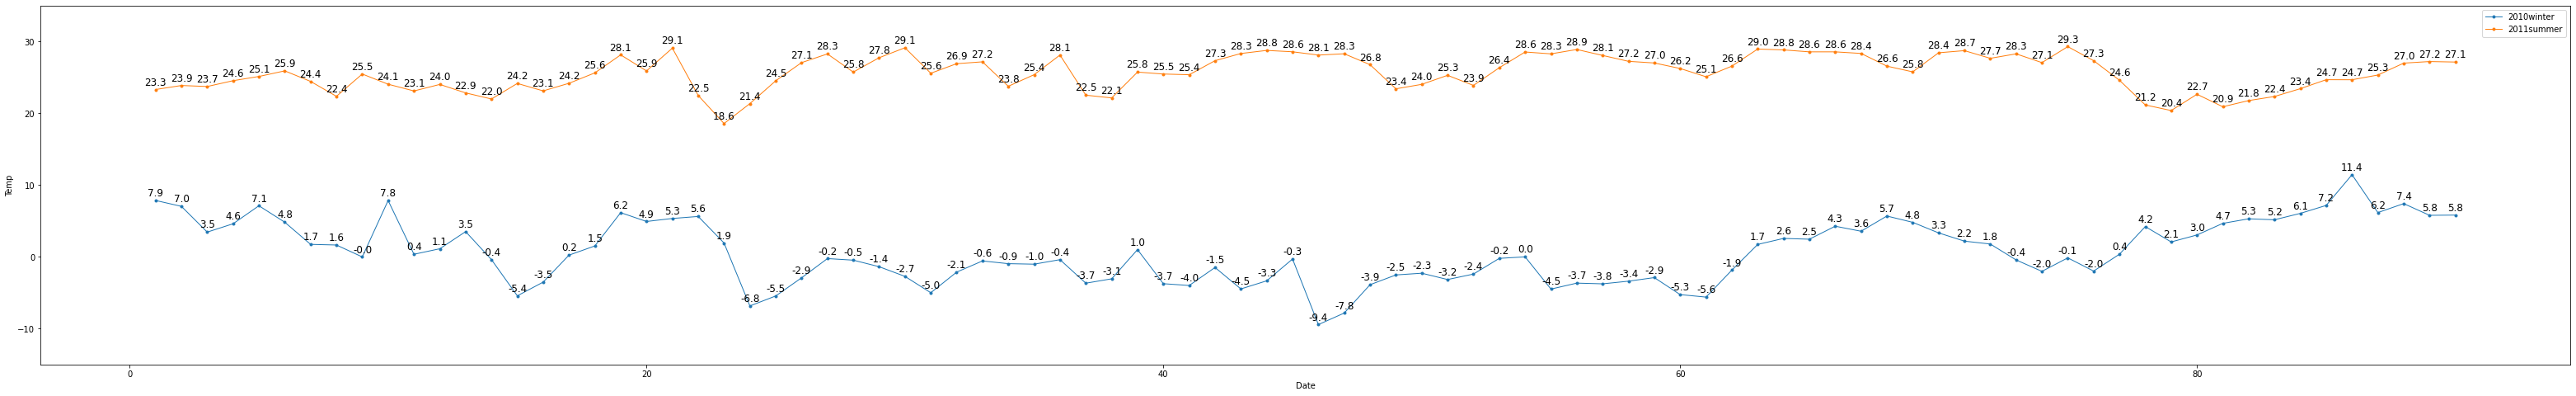

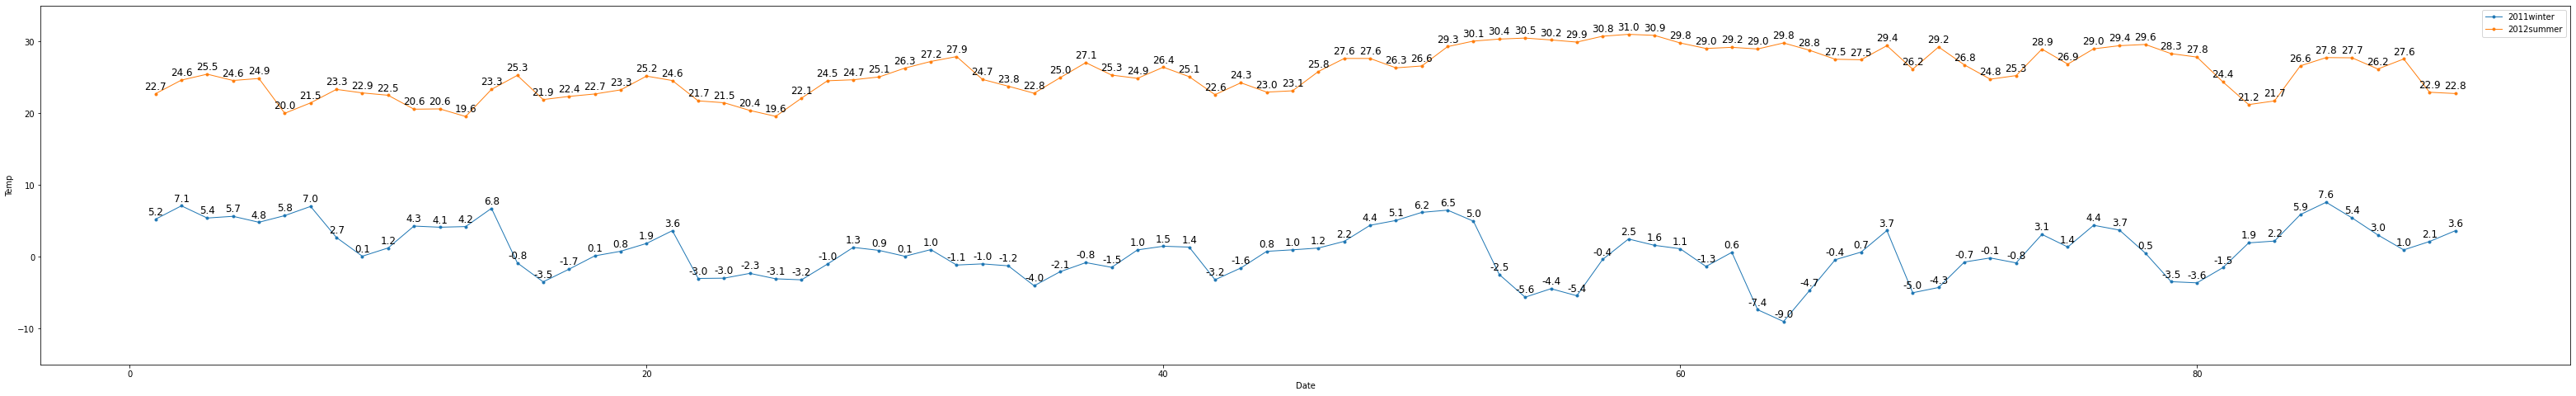

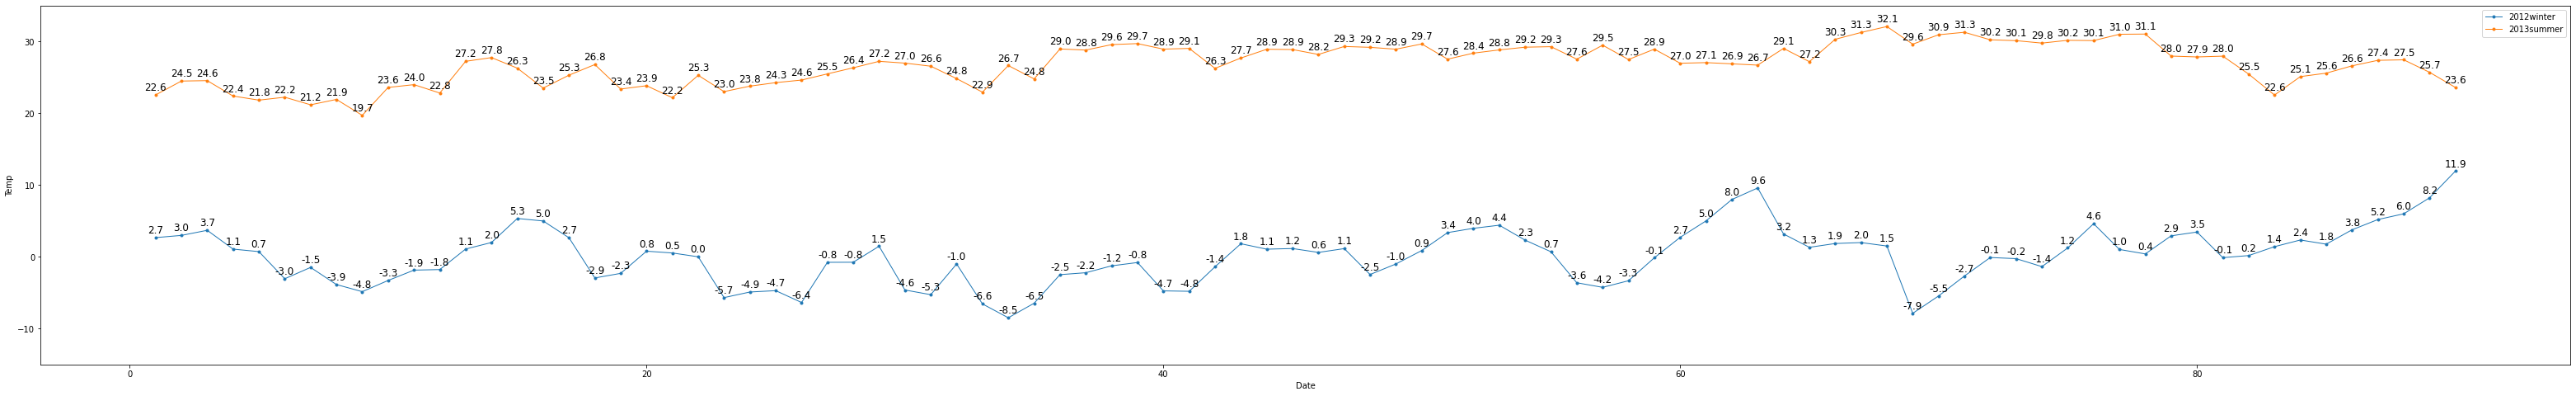

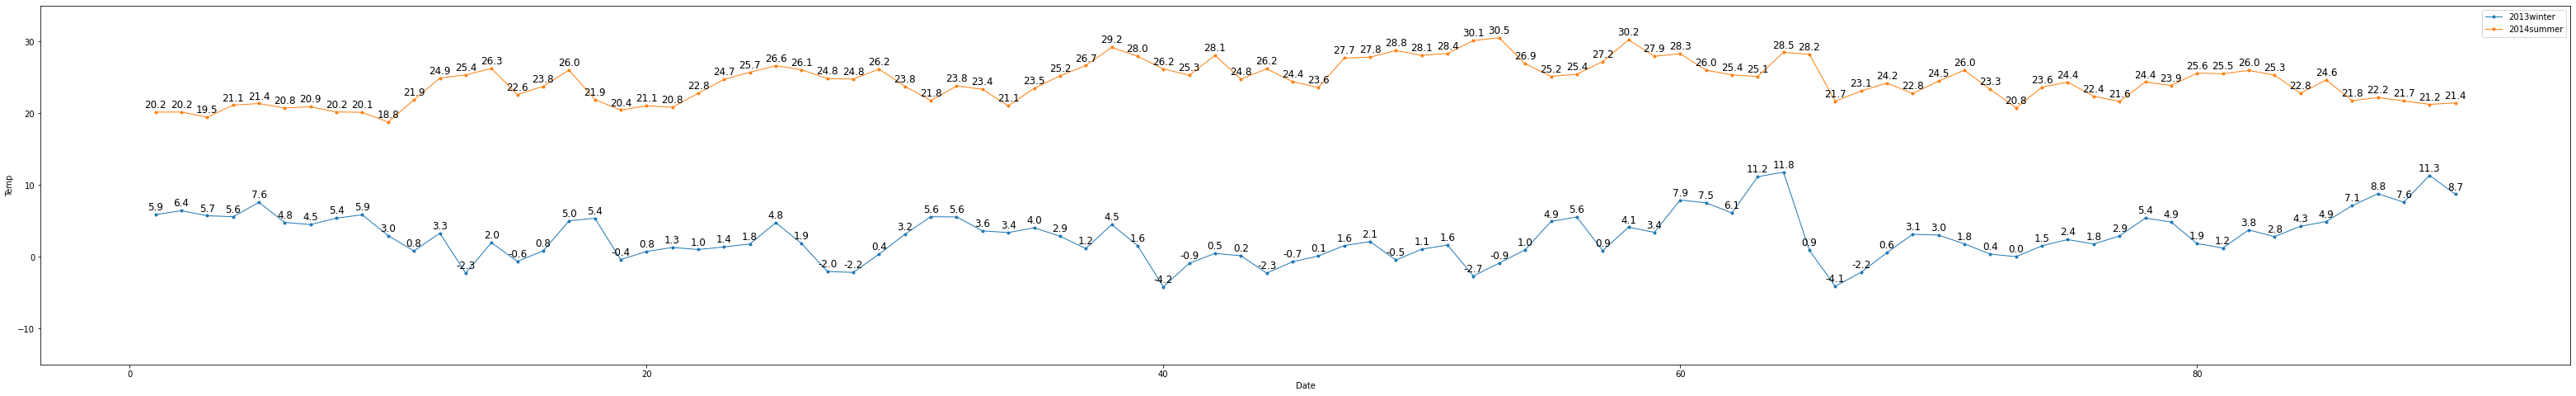

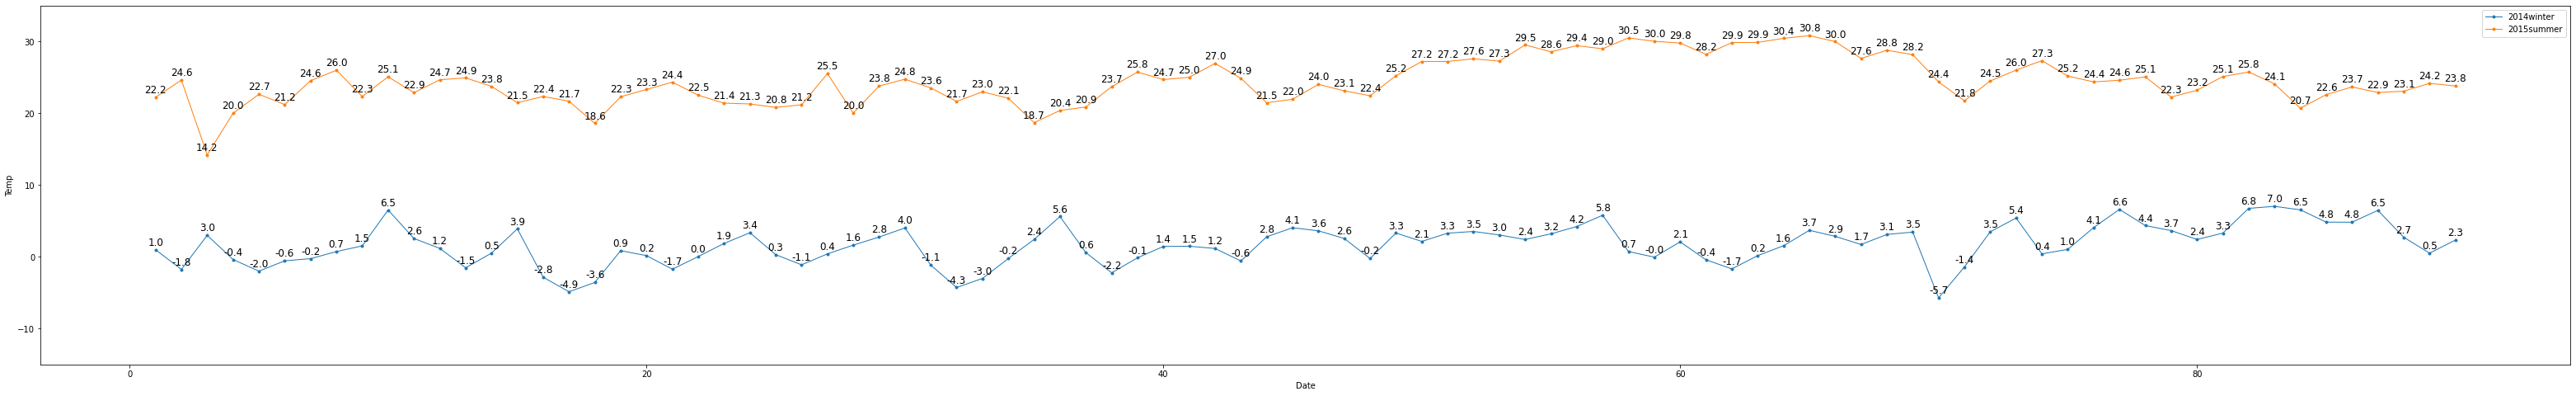

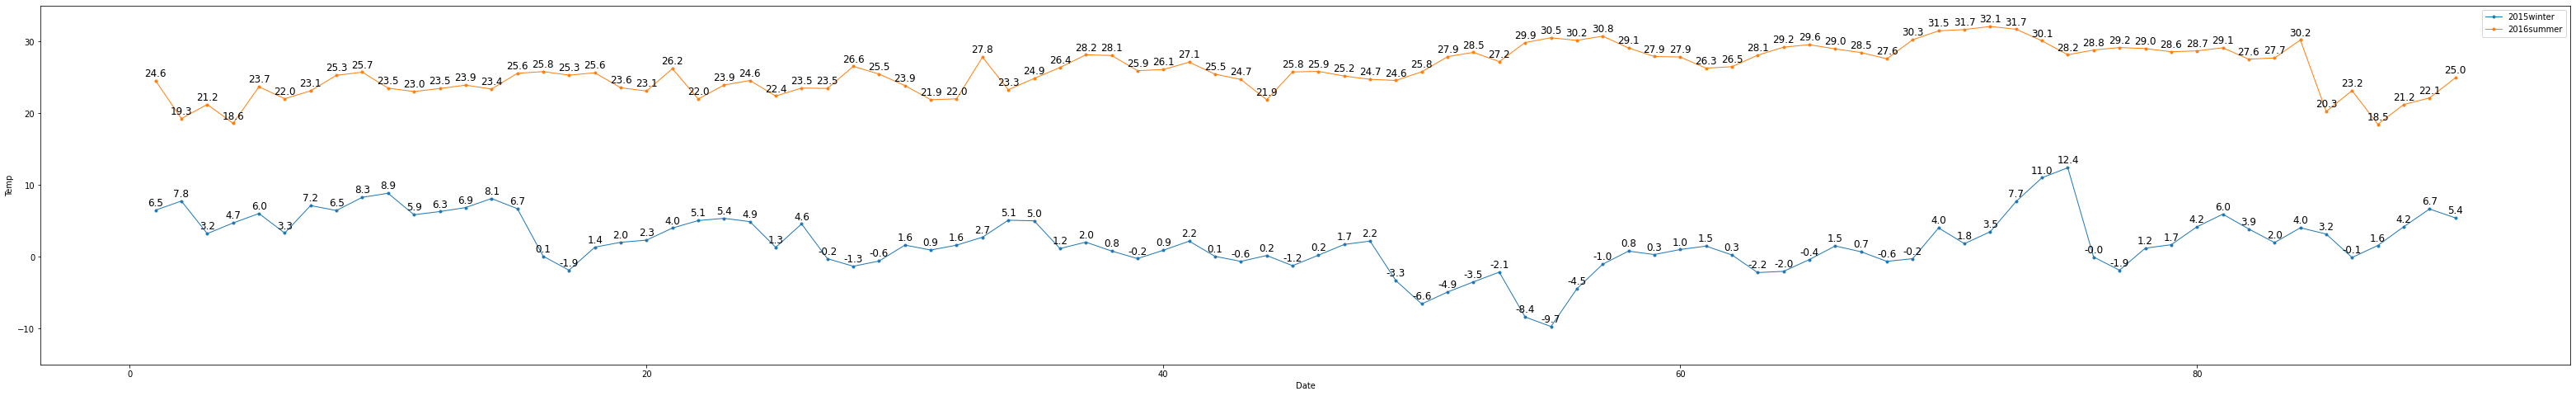

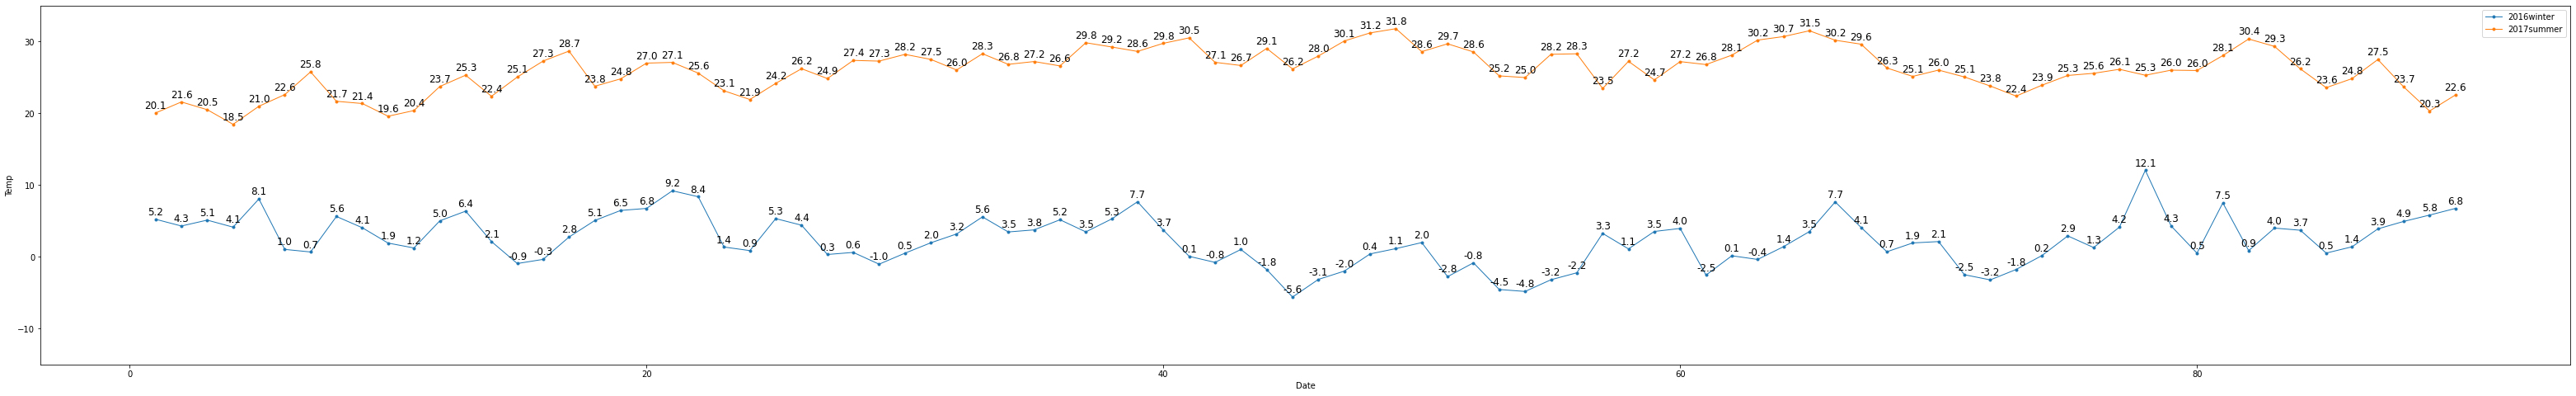

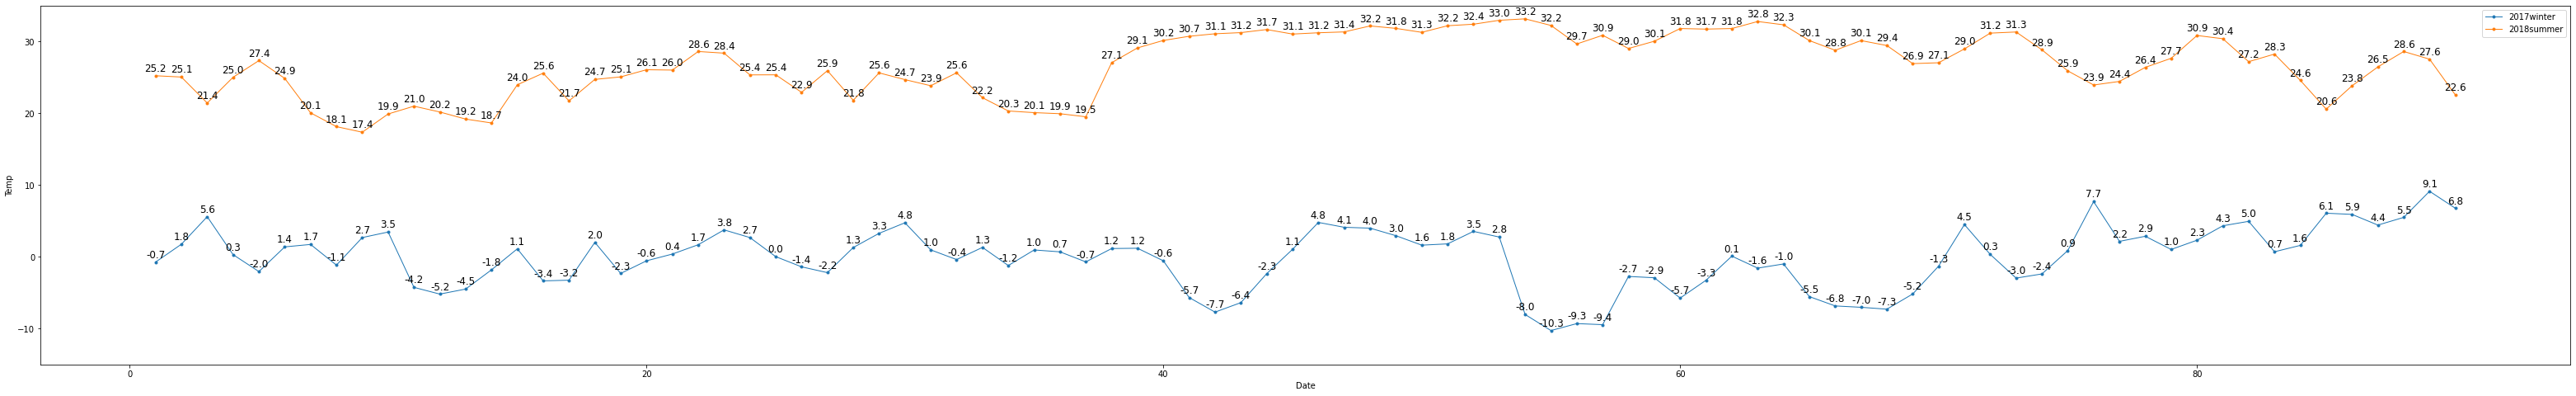

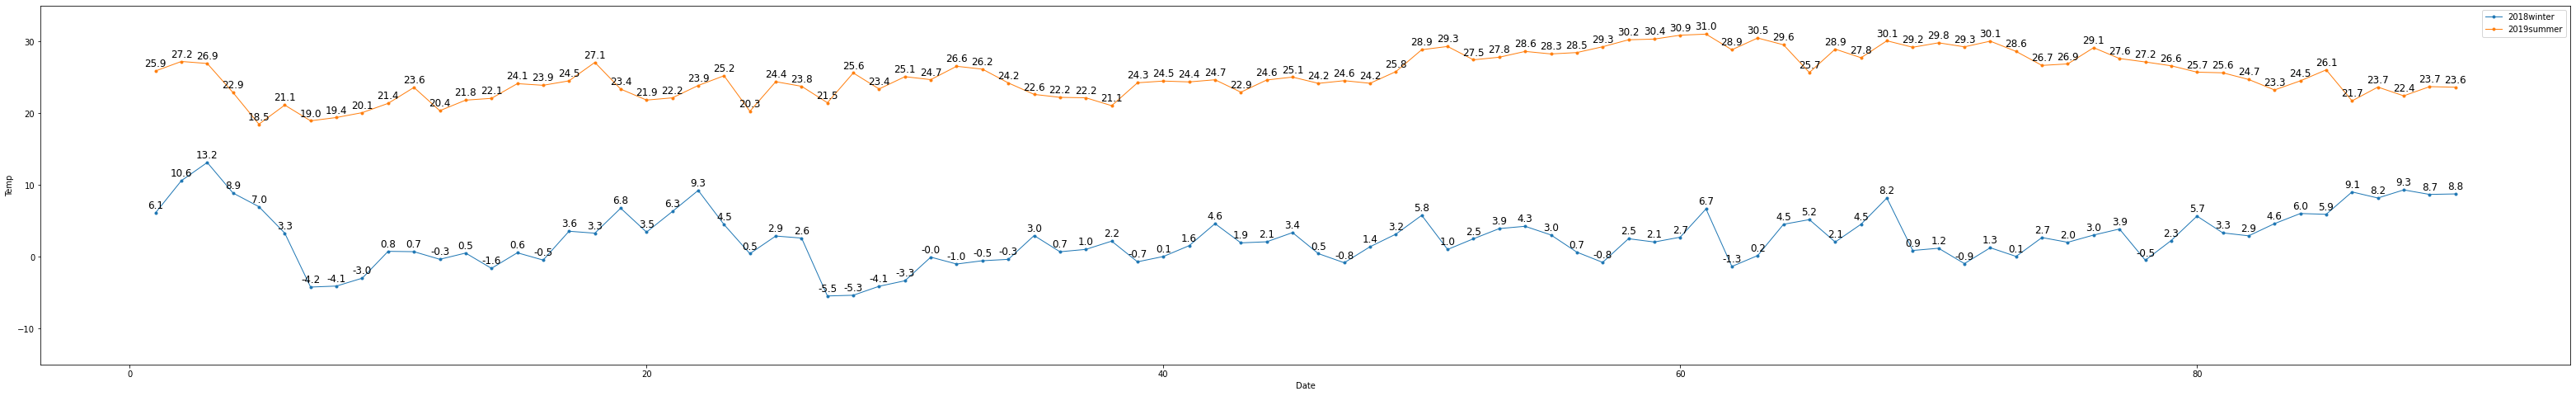

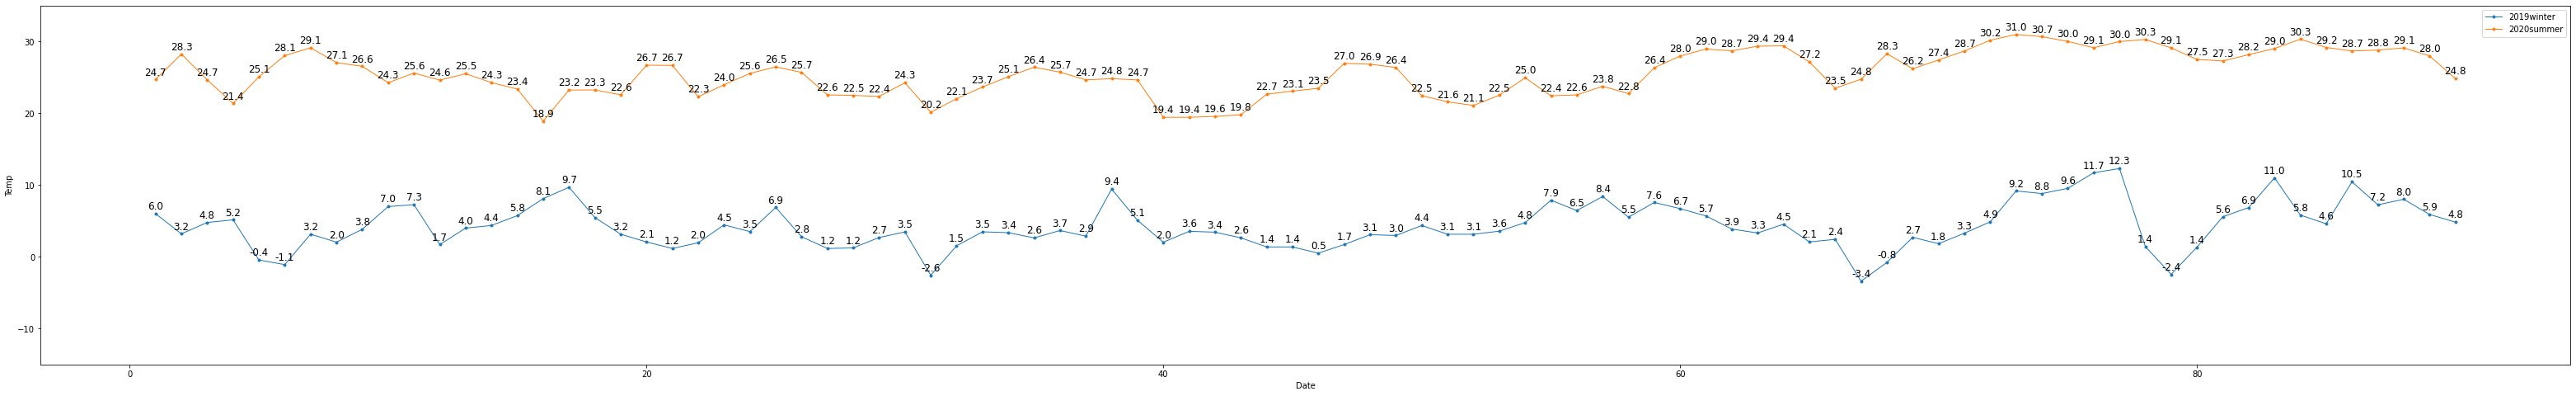

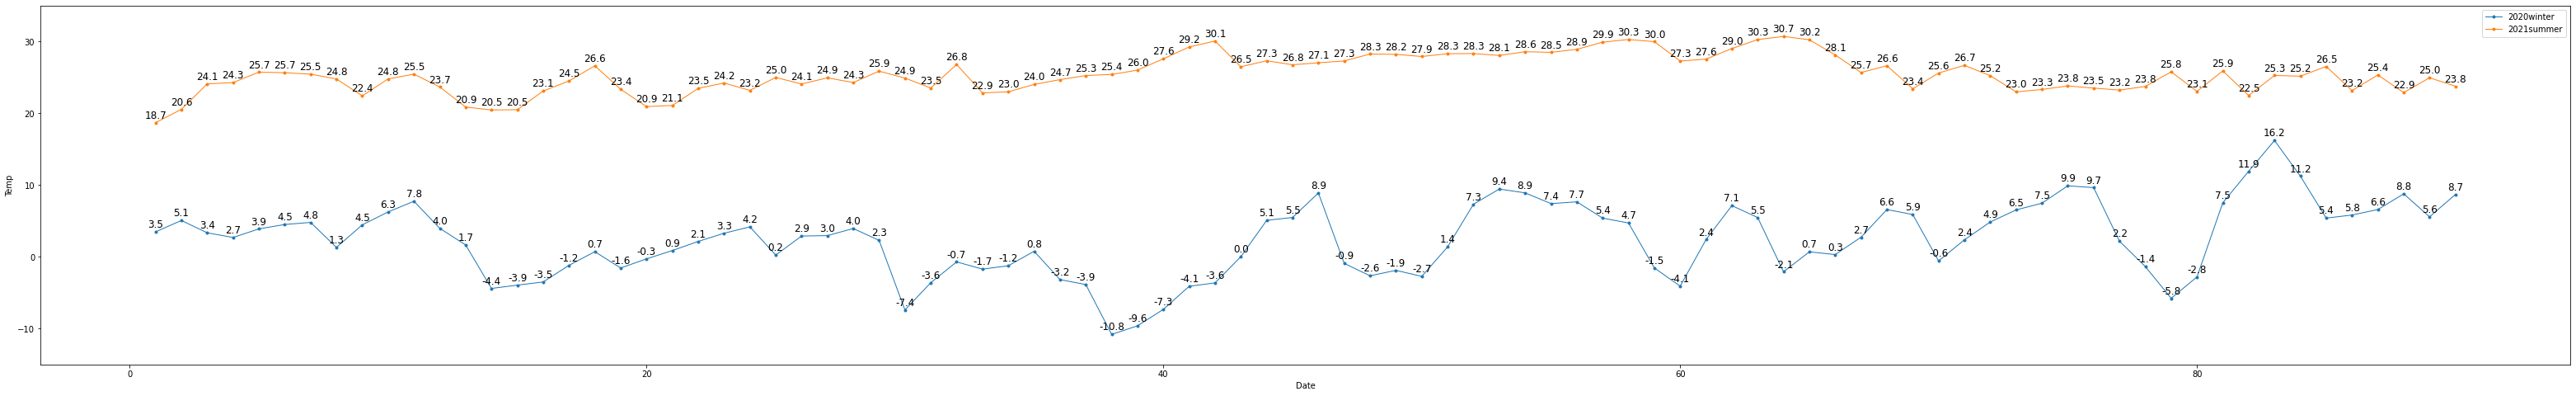

In [20]:
for i in range(2010,2021):
    win_sum_graph(i,i+1)

### Ⅱ. 작년 겨울과 올해 여름의 열지수(HI) 그래프

#### ①. 필요한 column 불러오기

필요한 열지수 정보만 가져옴

In [21]:
HI=temp_pre.loc[:,['year','month','day','hour','HI','region']]
HI.head()

,year,month,day,hour,HI,region
0,2010,6,1,0,15.589444,동인동
1,2010,6,1,1,17.245000,동인동
2,2010,6,1,2,18.926667,동인동
3,2010,6,1,3,20.006111,동인동
4,2010,6,1,4,21.415556,동인동


#### ②. HI가 33 이상인 폭염인 시간대를 찾아봄

1. 열지수 33 이상인 시간대만 뽑아낸 데이터프레임

In [22]:
index=list(HI[(HI['HI']>=33)].index)
HIGH=HI.loc[index,:]
# HIGH[HIGH['month']==5].count()
HIGH.count()

year      603880
month     603880
day       603880
hour      603880
HI        603880
region    603880
dtype: int64

2. 위의 데이터프레임에서 각 월별로 시간대를 카운팅

In [23]:
for i in range(3):
    print('{0}월 총 폭염 시간 수: '.format((i+6))+str(len(HIGH[HIGH['month']==(i+6)]))+'시간',end='\n')

6월 총 폭염 시간 수: 13513시간
7월 총 폭염 시간 수: 261762시간
8월 총 폭염 시간 수: 311003시간


3. 위의 결과를 년도별로 쪼개어 확인

In [24]:
for j in range(2010,2022):
    temp_HIGH=HIGH[HIGH['year']==j]
    for i in range(4):
        print('{0}년 {1}월 총 폭염 시간 수: '.format(j,(i+6))+str(len(temp_HIGH[temp_HIGH['month']==(i+6)]))+'시간',end='\n')
    print()

2010년 6월 총 폭염 시간 수: 1769시간
2010년 7월 총 폭염 시간 수: 19740시간
2010년 8월 총 폭염 시간 수: 42378시간
2010년 9월 총 폭염 시간 수: 9390시간

2011년 6월 총 폭염 시간 수: 3177시간
2011년 7월 총 폭염 시간 수: 18735시간
2011년 8월 총 폭염 시간 수: 19734시간
2011년 9월 총 폭염 시간 수: 4551시간

2012년 6월 총 폭염 시간 수: 40시간
2012년 7월 총 폭염 시간 수: 22656시간
2012년 8월 총 폭염 시간 수: 25951시간
2012년 9월 총 폭염 시간 수: 4시간

2013년 6월 총 폭염 시간 수: 1072시간
2013년 7월 총 폭염 시간 수: 33611시간
2013년 8월 총 폭염 시간 수: 39455시간
2013년 9월 총 폭염 시간 수: 610시간

2014년 6월 총 폭염 시간 수: 105시간
2014년 7월 총 폭염 시간 수: 16945시간
2014년 8월 총 폭염 시간 수: 5070시간
2014년 9월 총 폭염 시간 수: 50시간

2015년 6월 총 폭염 시간 수: 5시간
2015년 7월 총 폭염 시간 수: 11959시간
2015년 8월 총 폭염 시간 수: 12389시간
2015년 9월 총 폭염 시간 수: 0시간

2016년 6월 총 폭염 시간 수: 121시간
2016년 7월 총 폭염 시간 수: 17797시간
2016년 8월 총 폭염 시간 수: 32981시간
2016년 9월 총 폭염 시간 수: 1시간

2017년 6월 총 폭염 시간 수: 1968시간
2017년 7월 총 폭염 시간 수: 31345시간
2017년 8월 총 폭염 시간 수: 21243시간
2017년 9월 총 폭염 시간 수: 0시간

2018년 6월 총 폭염 시간 수: 1143시간
2018년 7월 총 폭염 시간 수: 48215시간
2018년 8월 총 폭염 시간 수: 34892시간
2018년 9월 총 폭염 시간 수: 0시간

2019년 6월 총 폭염 시간 수: 301시간
2

#### ③. 매년 폭염인 달의 시간대를 시각화

In [25]:
def HI_graph(m,y):
    xs=[str(i+6)+'th month' for i in range(3)]
    ys=y


    plt.figure(figsize=(10,6)) #그래프 크기 지정

    plt.plot(xs,ys,'o-',ms=3,lw=1)
    # plt.xlabel('Month') #그래프 x축 이름(label) 지정
    plt.title('{0}th year summer HI count'.format(m))
    plt.ylabel('HI')
    plt.ylim(0,50000)
    # plt.legend()

    for i in range(len(xs)):
        height=ys[i]
        plt.text(xs[i],height+0.25,'%.f hour'%height,ha='center',va='bottom',size=12)
    
    plt.savefig(str(j)+'년도 여름 열지수')

In [26]:
for j in range(2010,2022):
    HI_temp=[]
    temp_HIGH=HIGH[HIGH['year']==j]
    # print('{0}년 폭염 시간 수: '.format(j))
    for i in range(3):
        HI_temp.append(len(temp_HIGH[temp_HIGH['month']==(i+6)]))
    # HI_graph(j,HI_temp)
    # time.sleep(1)
    print(HI_temp)
    # print()

[1769, 19740, 42378]
[3177, 18735, 19734]
[40, 22656, 25951]
[1072, 33611, 39455]
[105, 16945, 5070]
[5, 11959, 12389]
[121, 17797, 32981]
[1968, 31345, 21243]
[1143, 48215, 34892]
[301, 12623, 22858]
[3528, 2780, 41096]
[284, 25356, 12956]


#### ④. HI가 -10 이하인 한파인 시간대를 찾아봄

1. 열지수가 -10 이하인 시간대만 뽑아낸 데이터프레임

In [27]:
index=list(HI[(HI['HI']<=-10)].index)
LOW=HI.loc[index,:]
# LOW[LOW['month']==1].count()
LOW.count()

year      27080
month     27080
day       27080
hour      27080
HI        27080
region    27080
dtype: int64

2. 한파인 달을 찾아봄

In [28]:
LOW['month'].unique()

array([ 1,  2, 12], dtype=int64)

3. 월별로 한파인 시간대를 카운팅

In [29]:
for i in range(1):
    print('{0}월 총 한파 시간 수: '.format((i+12))+str(len(LOW[LOW['month']==(i+12)]))+'시간',end='\n')

for i in range(2):
    print('{0}월 총 한파 시간 수: '.format((i+1))+str(len(LOW[LOW['month']==(i+1)]))+'시간',end='\n')

12월 총 한파 시간 수: 2069시간
1월 총 한파 시간 수: 19087시간
2월 총 한파 시간 수: 5924시간


4. 위의 결과를 년도별로 쪼개어 확인

In [30]:
for j in range(2010,2022):
    temp_LOW=LOW[LOW['year']==j]
    for i in range(1):
        print('{0}년 {1}월 총 한파 시간 수: '.format(j,(i+12))+str(len(temp_LOW[temp_LOW['month']==(i+12)]))+'시간',end='\n')
    for i in range(2):
        print('{0}년 {1}월 총 한파 시간 수: '.format(j,(i+1))+str(len(temp_LOW[temp_LOW['month']==(i+1)]))+'시간',end='\n')
    print()

2010년 12월 총 한파 시간 수: 293시간
2010년 1월 총 한파 시간 수: 0시간
2010년 2월 총 한파 시간 수: 0시간

2011년 12월 총 한파 시간 수: 0시간
2011년 1월 총 한파 시간 수: 2597시간
2011년 2월 총 한파 시간 수: 0시간

2012년 12월 총 한파 시간 수: 796시간
2012년 1월 총 한파 시간 수: 144시간
2012년 2월 총 한파 시간 수: 2260시간

2013년 12월 총 한파 시간 수: 0시간
2013년 1월 총 한파 시간 수: 1765시간
2013년 2월 총 한파 시간 수: 1453시간

2014년 12월 총 한파 시간 수: 0시간
2014년 1월 총 한파 시간 수: 0시간
2014년 2월 총 한파 시간 수: 0시간

2015년 12월 총 한파 시간 수: 0시간
2015년 1월 총 한파 시간 수: 5시간
2015년 2월 총 한파 시간 수: 65시간

2016년 12월 총 한파 시간 수: 0시간
2016년 1월 총 한파 시간 수: 3159시간
2016년 2월 총 한파 시간 수: 0시간

2017년 12월 총 한파 시간 수: 153시간
2017년 1월 총 한파 시간 수: 22시간
2017년 2월 총 한파 시간 수: 0시간

2018년 12월 총 한파 시간 수: 11시간
2018년 1월 총 한파 시간 수: 7209시간
2018년 2월 총 한파 시간 수: 2127시간

2019년 12월 총 한파 시간 수: 0시간
2019년 1월 총 한파 시간 수: 0시간
2019년 2월 총 한파 시간 수: 0시간

2020년 12월 총 한파 시간 수: 258시간
2020년 1월 총 한파 시간 수: 0시간
2020년 2월 총 한파 시간 수: 0시간

2021년 12월 총 한파 시간 수: 558시간
2021년 1월 총 한파 시간 수: 4170시간
2021년 2월 총 한파 시간 수: 0시간



#### ⑤. 작년 겨울과 올해 여름의 3달간 기록을 비교하여 시각화

1. 시각화한 후 저장하는 함수

In [31]:
def HI_graph(m,H,L):
    xs=[1,2,3]
    y1=H
    y2=L


    fig,ax1=plt.subplots(figsize=(15,6))
    ax1.set_ylabel('Heat Wave')
    ax1.set_xticks([1,2,3])
    ax1.set_ylim([0,50000])
    ax1.set_title(str(m+1)+' year Heat_Index comparison',size=24,family='fantasy')
    line1=ax1.plot(xs,y1,color='red',label=str(m+1)+' Summer')

    ax2=ax1.twinx()
    ax2.set_ylabel('Cold Wave')
    ax2.set_ylim([0,7500])
    line2=ax2.plot(xs,y2,color='blue',label=str(m)+' Winter')

    lines=line1+line2
    labels=[l.get_label() for l in lines]
    prop = dict(
        # family='fantasy', # 글씨체
        style='italic', # 글씨 형식 - 이탤릭형식
        size=18 # 글씨 크기
    )
    
    config_legend=dict(## 범례 설정
        loc='upper left', # 범례 위치 설정
        prop=prop # 범례 폰트 속성
    )
    ax1.legend(lines,labels,**config_legend)

    for i in range(len(xs)):
        height=y1[i]
        ax1.text(xs[i],height+0.7,'%.f hour'%height,ha='center',va='bottom',size=12)
            
    for i in range(len(xs)):
        height=y2[i]
        ax2.text(xs[i],height+0.15,'%.f hour'%height,ha='center',va='bottom',size=12)

    plt.savefig(str(m)+'년도 겨울과 여름의 열지수')

2. 여름 및 겨울의 3달간 열지수를 그래프로 나타냄

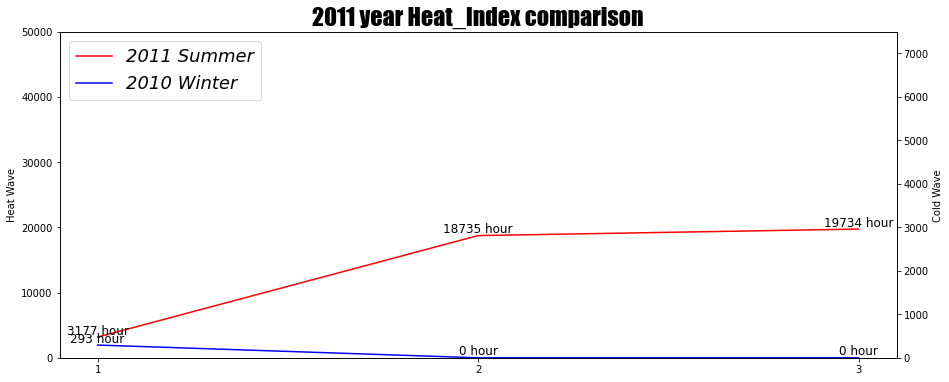

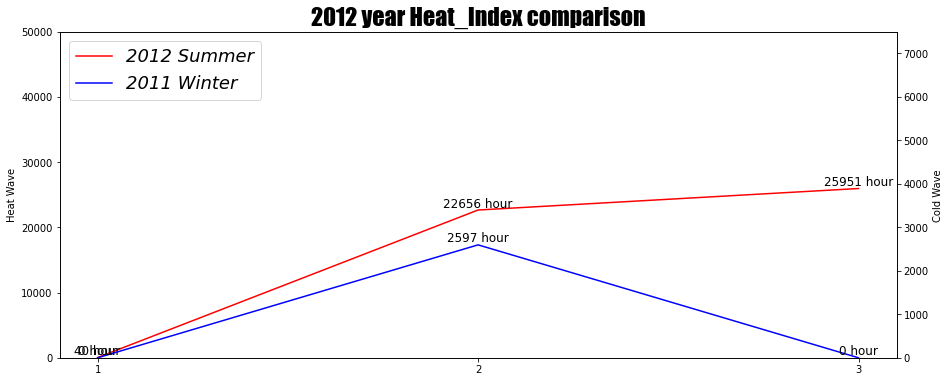

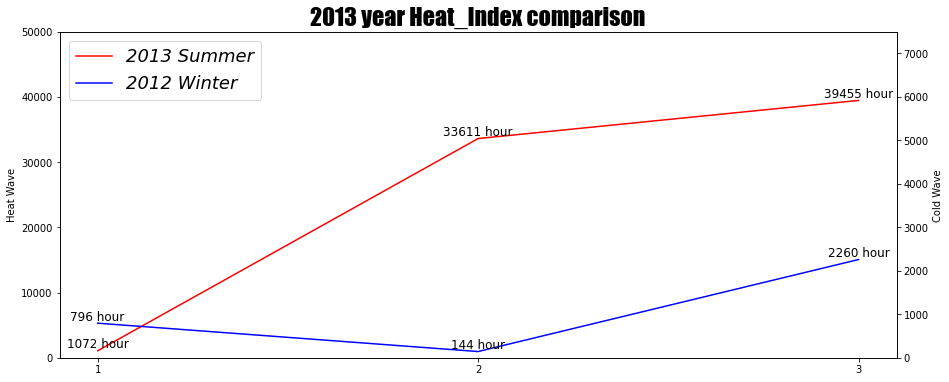

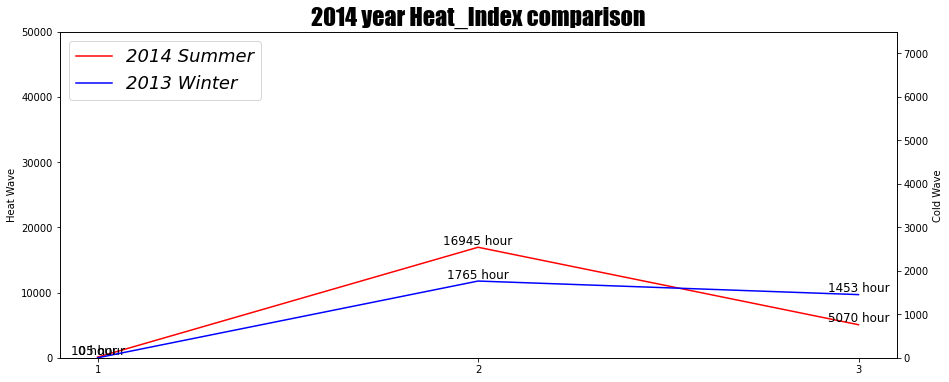

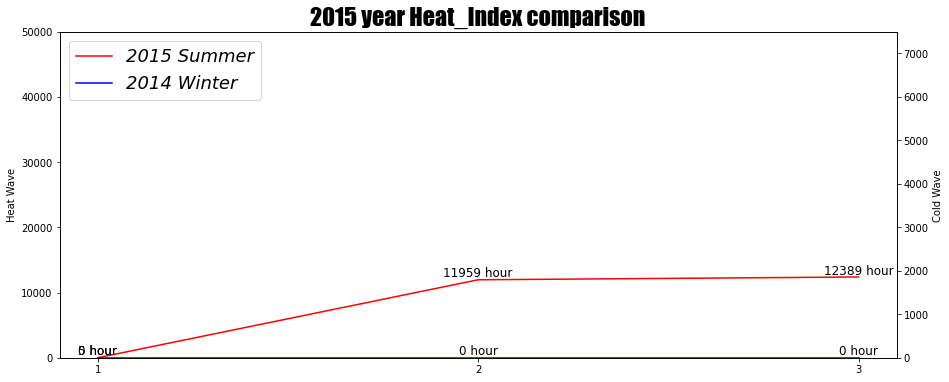

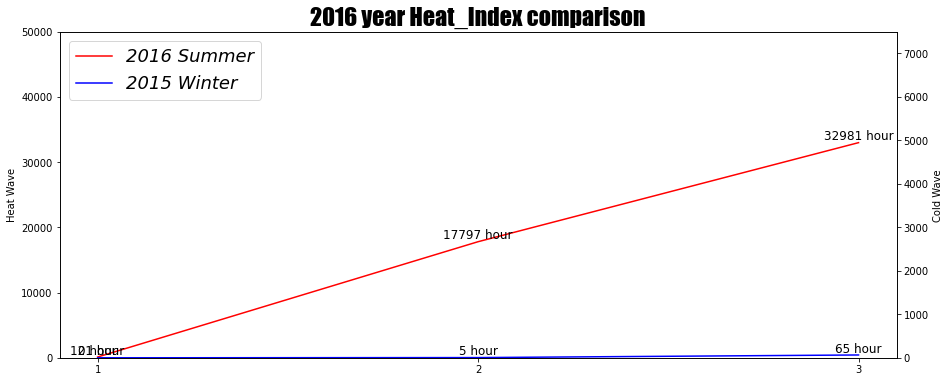

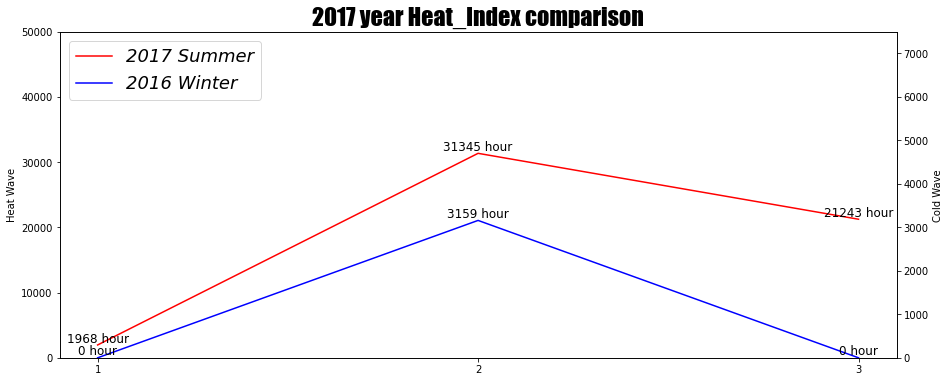

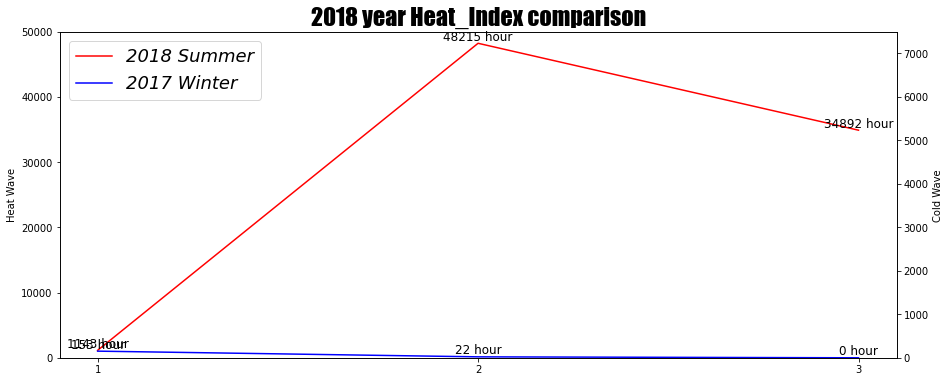

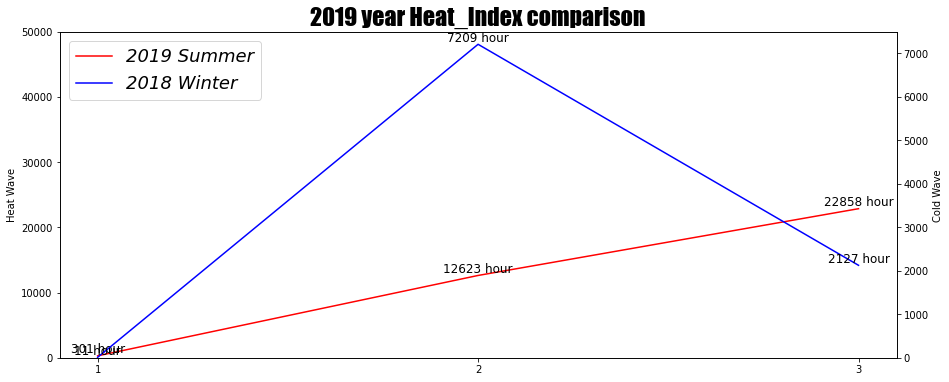

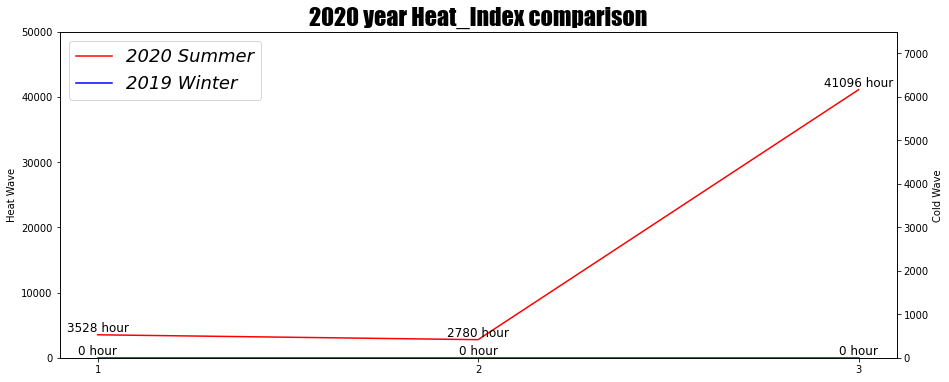

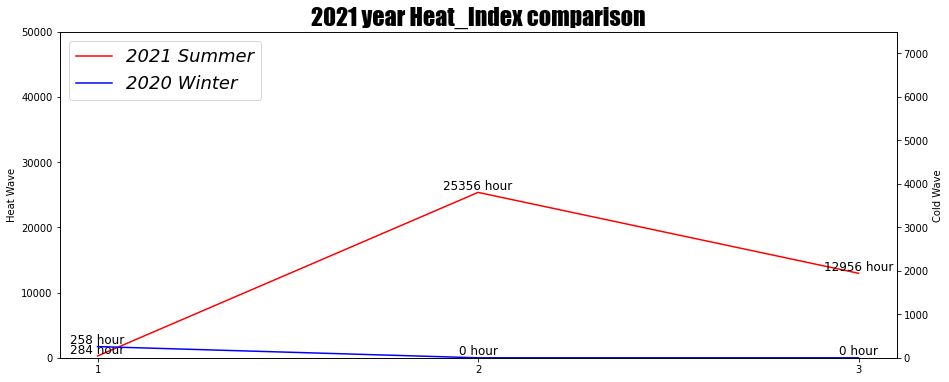

In [32]:
# 2011년 부터 2021년까지를 비교하여 시각화한 것을 저장하는 코드
for j in range(2010,2021):
    temp_HIGH=HIGH[HIGH['year']==j+1]
    summer_high=[]
    for i in range(3):
        summer_high.append(len(temp_HIGH[temp_HIGH['month']==(i+6)]))

    temp_LOW=LOW[LOW['year']==j]
    winter_low=[]
    for i in range(1):
        winter_low.append(len(temp_LOW[temp_LOW['month']==(i+12)]))
    for i in range(2):
        winter_low.append(len(temp_LOW[temp_LOW['month']==(i+1)]))

    HI_graph(j,summer_high,winter_low)

#### ⑥. 작년 겨울과 올해 여름의 4달간 기록을 비교하여 시각화

1. 열지수 33 이상인 시간대만 추출

In [33]:
index=list(HI[(HI['HI']>=33)].index)
HIGH=HI.loc[index,:]
# HIGH[HIGH['month']==5].count()
HIGH.count()

year      603880
month     603880
day       603880
hour      603880
HI        603880
region    603880
dtype: int64

2. 열지수 -10 이하인 시간대만 추출

In [34]:
index=list(HI[(HI['HI']<=-10)].index)
LOW=HI.loc[index,:]
# LOW[LOW['month']==1].count()
LOW.count()

year      27080
month     27080
day       27080
hour      27080
HI        27080
region    27080
dtype: int64

3. 겨울과 여름의 시작부터 4달간의 열지수 시간대 그래프

In [35]:
# 시각화 한 후 저장까지 함
def HI_graph(m,H,L):
    xs=[1,2,3,4]
    y1=H
    y2=L


    fig,ax1=plt.subplots(figsize=(15,6))
    ax1.set_ylabel('Heat Wave')
    ax1.set_xticks([1,2,3,4])
    ax1.set_ylim([0,50000])
    ax1.set_title(str(m+1)+' year Heat_Index comparison',size=24,family='fantasy')
    line1=ax1.plot(xs,y1,color='red',label=str(m+1)+' Summer')

    ax2=ax1.twinx()
    ax2.set_ylabel('Cold Wave')
    ax2.set_ylim([0,8000])
    line2=ax2.plot(xs,y2,color='blue',label=str(m)+' Winter')

    lines=line1+line2
    labels=[l.get_label() for l in lines]
    prop = dict(
        # family='fantasy', # 글씨체
        style='italic', # 글씨 형식 - 이탤릭형식
        size=18 # 글씨 크기
    )
    
    config_legend=dict(## 범례 설정
        loc='upper left', # 범례 위치 설정
        prop=prop # 범례 폰트 속성
    )
    ax1.legend(lines,labels,**config_legend)

    for i in range(len(xs)):
        height=y1[i]
        ax1.text(xs[i],height+0.7,'%.f hour'%height,ha='center',va='bottom',size=12)
            
    for i in range(len(xs)):
        height=y2[i]
        ax2.text(xs[i],height+0.15,'%.f hour'%height,ha='center',va='bottom',size=12)

    plt.savefig(str(m)+'년도 겨울과 여름의 열지수')

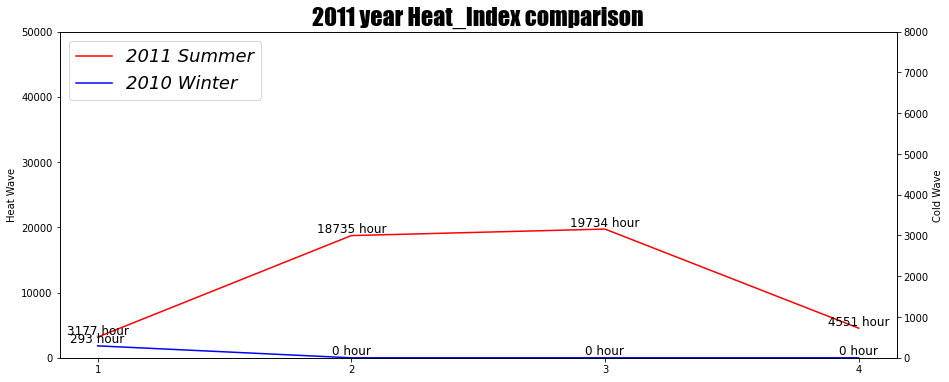

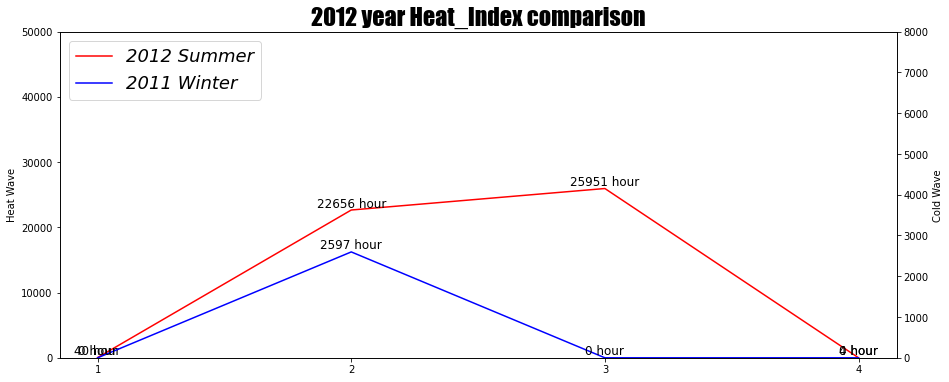

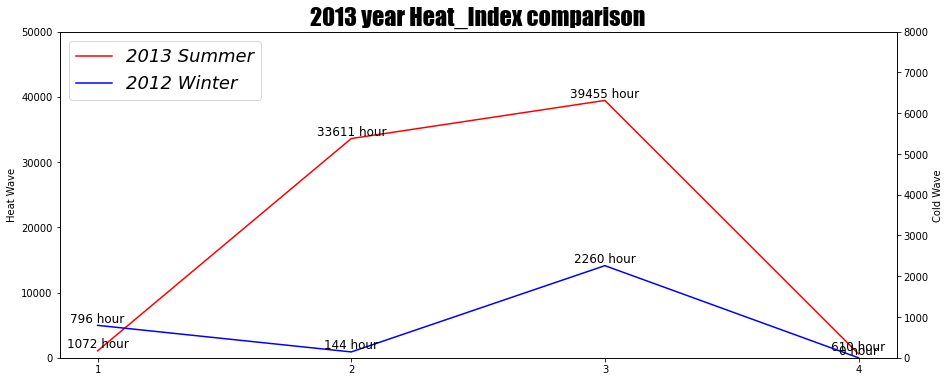

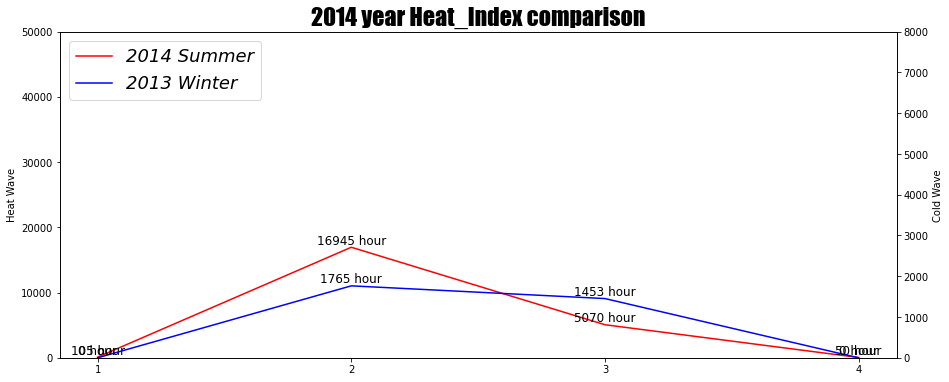

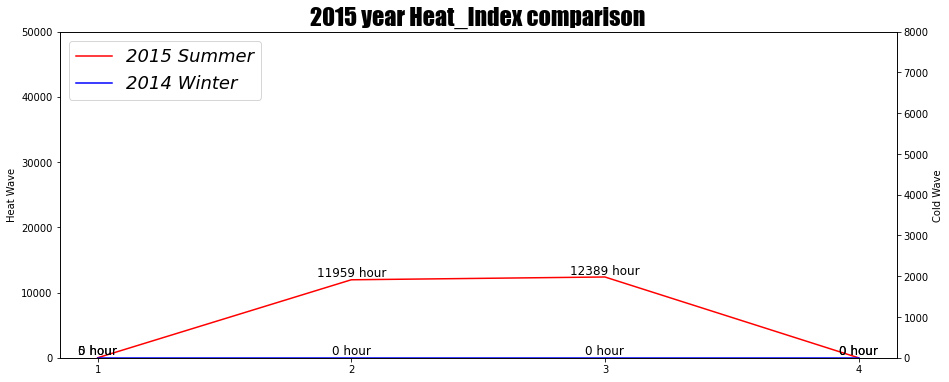

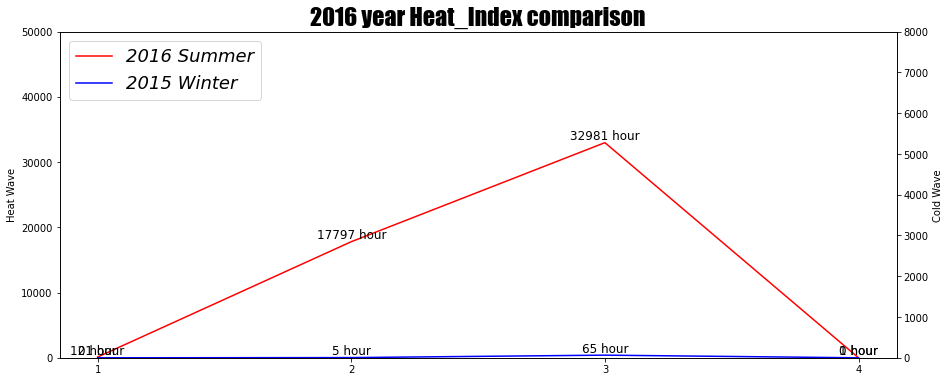

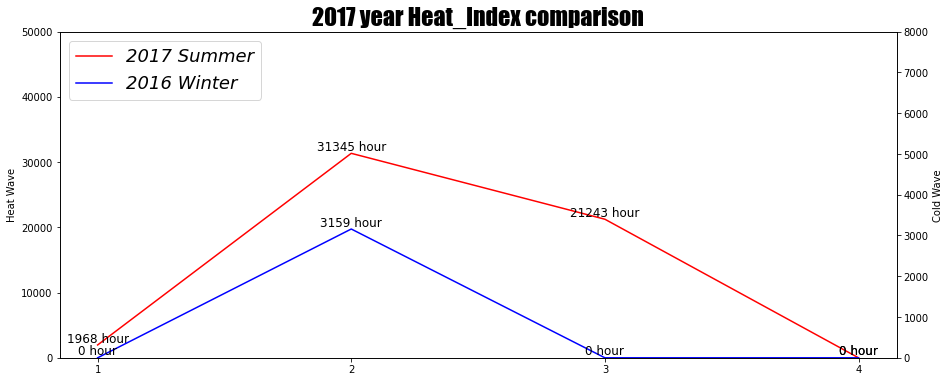

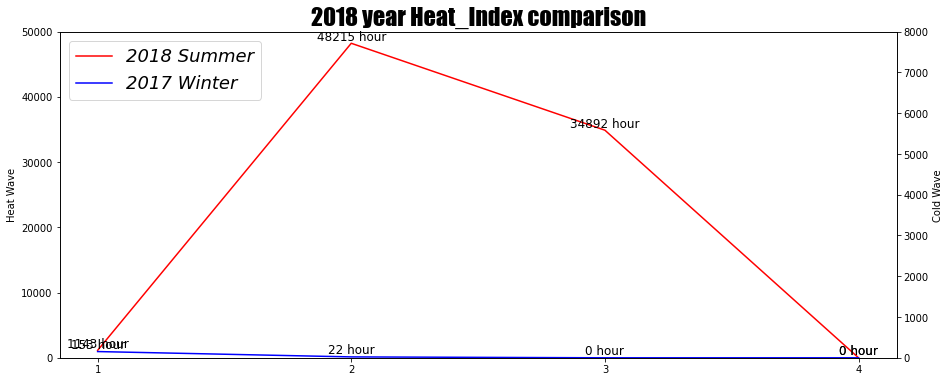

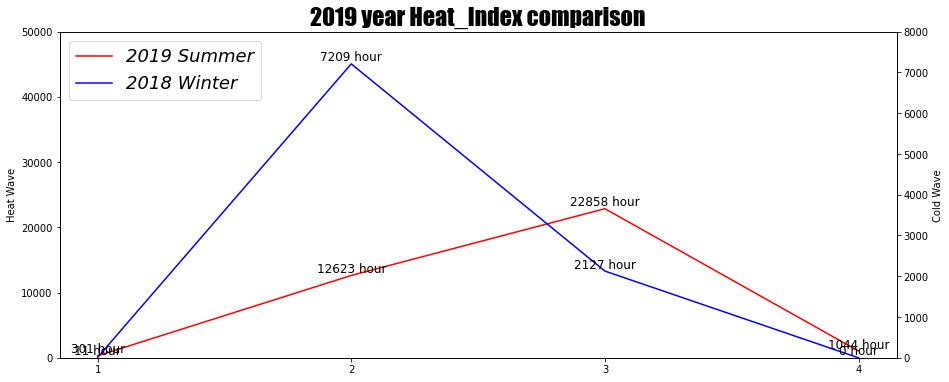

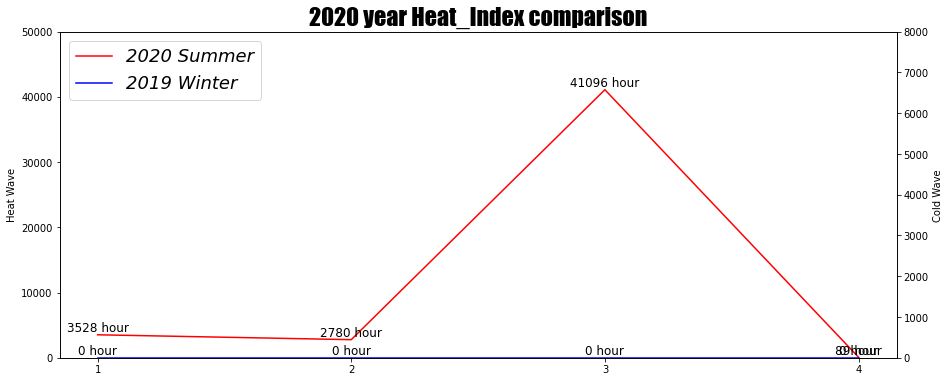

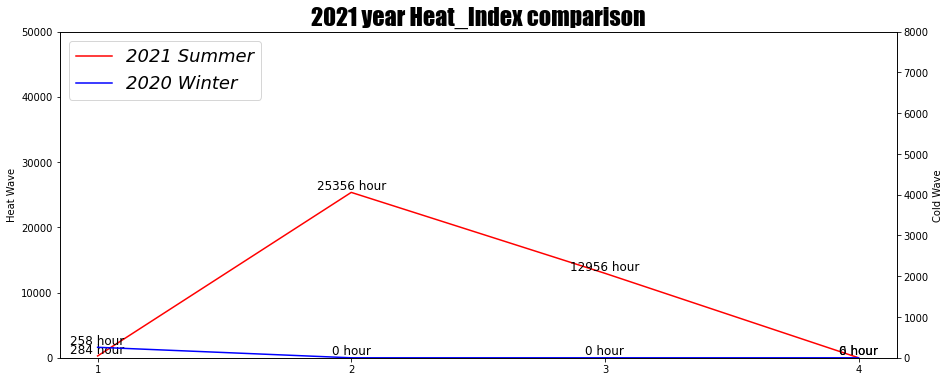

In [36]:
# 2011년 부터 2021년까지를 비교하여 시각화한 것을 저장하는 코드
for j in range(2010,2021):
    temp_HIGH=HIGH[HIGH['year']==j+1]
    summer_high=[]
    for i in range(4):
        summer_high.append(len(temp_HIGH[temp_HIGH['month']==(i+6)]))

    temp_LOW=LOW[LOW['year']==j]
    winter_low=[]
    for i in range(1):
        winter_low.append(len(temp_LOW[temp_LOW['month']==(i+12)]))
    for i in range(3):
        winter_low.append(len(temp_LOW[temp_LOW['month']==(i+1)]))
    
    HI_graph(j,summer_high,winter_low)

-------------------
**그래프 관찰결과**
* 2012년이나 2014년 그래프를 보면 2018년 그래프에 비하여 대체로 한파인 시간대가 많음.
* 2018년 그래프는 지정한 그래프보다 대체로 폭염인 시간대가 많음.


* 따라서 겨울에 한파인 시간대가 적으면 대체로 여름에 폭염인 시간대가 늘어남을 알 수 있음.
-------------------


## 3. 작년 겨울의 한파시간과 올해 여름의 폭염시간의 상관관계

### Ⅰ. RAW 데이터의 상관관계 히트맵

<AxesSubplot:>

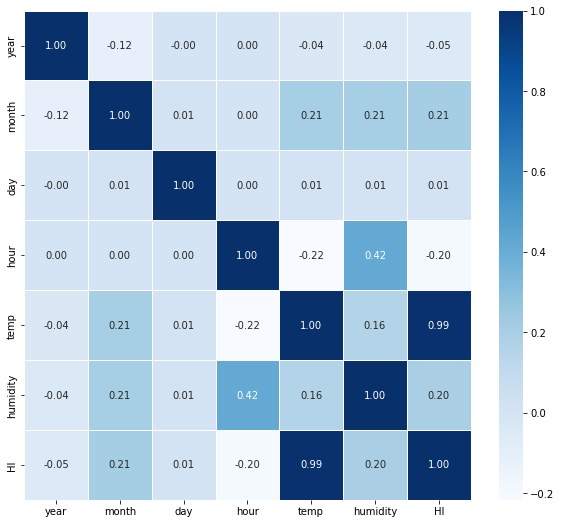

In [37]:
plt.figure(figsize=(10,9))
sns.heatmap(data = temp_pre.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

### Ⅱ. 폭염 혹은 한파인 시간대를 카운팅

#### ①. 열지수가 25이상인 시간대를 카운팅

In [90]:
index=list(HI[(HI['HI']>=25)].index)
HIGH=HI.loc[index,:]
HIGH.count()

year      2713648
month     2713648
day       2713648
hour      2713648
HI        2713648
region    2713648
dtype: int64

#### ②. 열지수가 -3이하인 시간대를 카운팅

In [91]:
index=list(HI[(HI['HI']<=-3)].index)
LOW=HI.loc[index,:]
LOW.count()

year      600644
month     600644
day       600644
hour      600644
HI        600644
region    600644
dtype: int64

#### ③. 연도별로 폭염 시간대를 카운팅

In [40]:
for j in range(2010,2022):
    temp_HIGH=HIGH[HIGH['year']==j]
    for i in range(4):
        print('{0}년 {1}월 총 폭염 시간 수: '.format(j,(i+6))+str(len(temp_HIGH[temp_HIGH['month']==(i+6)]))+'시간',end='\n')
    print()

2010년 6월 총 폭염 시간 수: 46934시간
2010년 7월 총 폭염 시간 수: 69613시간
2010년 8월 총 폭염 시간 수: 99148시간
2010년 9월 총 폭염 시간 수: 41093시간

2011년 6월 총 폭염 시간 수: 45249시간
2011년 7월 총 폭염 시간 수: 78333시간
2011년 8월 총 폭염 시간 수: 72693시간
2011년 9월 총 폭염 시간 수: 32156시간

2012년 6월 총 폭염 시간 수: 26689시간
2012년 7월 총 폭염 시간 수: 75353시간
2012년 8월 총 폭염 시간 수: 84745시간
2012년 9월 총 폭염 시간 수: 14729시간

2013년 6월 총 폭염 시간 수: 38608시간
2013년 7월 총 폭염 시간 수: 94365시간
2013년 8월 총 폭염 시간 수: 89365시간
2013년 9월 총 폭염 시간 수: 23698시간

2014년 6월 총 폭염 시간 수: 27132시간
2014년 7월 총 폭염 시간 수: 69167시간
2014년 8월 총 폭염 시간 수: 45736시간
2014년 9월 총 폭염 시간 수: 21602시간

2015년 6월 총 폭염 시간 수: 26674시간
2015년 7월 총 폭염 시간 수: 57188시간
2015년 8월 총 폭염 시간 수: 60065시간
2015년 9월 총 폭염 시간 수: 13183시간

2016년 6월 총 폭염 시간 수: 34969시간
2016년 7월 총 폭염 시간 수: 68570시간
2016년 8월 총 폭염 시간 수: 80038시간
2016년 9월 총 폭염 시간 수: 19598시간

2017년 6월 총 폭염 시간 수: 39578시간
2017년 7월 총 폭염 시간 수: 90051시간
2017년 8월 총 폭염 시간 수: 70466시간
2017년 9월 총 폭염 시간 수: 21867시간

2018년 6월 총 폭염 시간 수: 35206시간
2018년 7월 총 폭염 시간 수: 80653시간
2018년 8월 총 폭염 시간 수: 85484시간
2018년 9월 총 폭

#### ④. 연도별로 한파 시간대를 카운팅

In [41]:
for j in range(2010,2022):
    temp_LOW=LOW[LOW['year']==j]
    for i in range(1):
        print('{0}년 {1}월 총 한파 시간 수: '.format(j,(i+12))+str(len(temp_LOW[temp_LOW['month']==(i+12)]))+'시간',end='\n')
    for i in range(3):
        print('{0}년 {1}월 총 한파 시간 수: '.format(j,(i+1))+str(len(temp_LOW[temp_LOW['month']==(i+1)]))+'시간',end='\n')
    print()

2010년 12월 총 한파 시간 수: 23291시간
2010년 1월 총 한파 시간 수: 0시간
2010년 2월 총 한파 시간 수: 0시간
2010년 3월 총 한파 시간 수: 0시간

2011년 12월 총 한파 시간 수: 15606시간
2011년 1월 총 한파 시간 수: 50562시간
2011년 2월 총 한파 시간 수: 4896시간
2011년 3월 총 한파 시간 수: 563시간

2012년 12월 총 한파 시간 수: 31659시간
2012년 1월 총 한파 시간 수: 23757시간
2012년 2월 총 한파 시간 수: 22975시간
2012년 3월 총 한파 시간 수: 979시간

2013년 12월 총 한파 시간 수: 6419시간
2013년 1월 총 한파 시간 수: 31415시간
2013년 2월 총 한파 시간 수: 11370시간
2013년 3월 총 한파 시간 수: 334시간

2014년 12월 총 한파 시간 수: 16739시간
2014년 1월 총 한파 시간 수: 13328시간
2014년 2월 총 한파 시간 수: 6055시간
2014년 3월 총 한파 시간 수: 198시간

2015년 12월 총 한파 시간 수: 4852시간
2015년 1월 총 한파 시간 수: 12874시간
2015년 2월 총 한파 시간 수: 6073시간
2015년 3월 총 한파 시간 수: 1678시간

2016년 12월 총 한파 시간 수: 4982시간
2016년 1월 총 한파 시간 수: 27772시간
2016년 2월 총 한파 시간 수: 10898시간
2016년 3월 총 한파 시간 수: 407시간

2017년 12월 총 한파 시간 수: 24573시간
2017년 1월 총 한파 시간 수: 23792시간
2017년 2월 총 한파 시간 수: 10189시간
2017년 3월 총 한파 시간 수: 366시간

2018년 12월 총 한파 시간 수: 19111시간
2018년 1월 총 한파 시간 수: 38487시간
2018년 2월 총 한파 시간 수: 25095시간
2018년 3월 총 한파 시간 수: 691시간

2019년 1

### Ⅲ. 폭염과 한파인 시간을 카운팅 한 데이터프레임을 생성

#### ①. 월별로 연도별 카운팅값을 담아준다.

In [124]:
summer_high1=[]
summer_high2=[]
summer_high3=[]
summer_high4=[]
winter_low1=[]
winter_low2=[]
winter_low3=[]
winter_low4=[]
for j in range(2010,2021):
    temp_HIGH=HIGH[HIGH['year']==j+1]
    summer_high1.append(len(temp_HIGH[temp_HIGH['month']==(6)]))
    summer_high2.append(len(temp_HIGH[temp_HIGH['month']==(7)]))
    summer_high3.append(len(temp_HIGH[temp_HIGH['month']==(8)]))
    summer_high4.append(len(temp_HIGH[temp_HIGH['month']==(9)]))

    temp_LOW=LOW[LOW['year']==j]
    winter_low1.append(len(temp_LOW[temp_LOW['month']==(12)]))
    winter_low2.append(len(temp_LOW[temp_LOW['month']==(1)]))
    winter_low3.append(len(temp_LOW[temp_LOW['month']==(2)]))
    winter_low4.append(len(temp_LOW[temp_LOW['month']==(3)]))


summer_high=summer_high1+summer_high2+summer_high3+summer_high4
winter_low=winter_low1+winter_low2+winter_low3+winter_low4
summer_high.sort()
winter_low.sort(reverse=True)
# random.shuffle(summer_high)
a=winter_low[5:35]
random.shuffle(a)
winter_low[5:35]=a
# random.shuffle(winter_low)
print(summer_high)
print(winter_low)

[13183, 14729, 16286, 17730, 18175, 19598, 21602, 21867, 23698, 26674, 26689, 27132, 31514, 31627, 32156, 32224, 33931, 34969, 35206, 38608, 39578, 45249, 45736, 46722, 57188, 59108, 60065, 64194, 68570, 69167, 70466, 72693, 75353, 78171, 78333, 80038, 80347, 80653, 84745, 85484, 89365, 90051, 94365, 98463]
[50562, 38487, 31659, 31415, 27772, 5089, 1678, 15606, 13328, 4896, 10189, 23792, 23291, 3001, 11370, 12874, 691, 16739, 6419, 24573, 17009, 563, 22975, 4982, 6073, 19111, 888, 10898, 6055, 979, 4816, 8915, 25095, 23757, 4852, 407, 366, 334, 198, 40, 8, 0, 0, 0]


#### ②. 카운팅한 값을 합하여 데이터프레임을 생성함

In [129]:
season_HI=pd.DataFrame({'HI_summer':summer_high,
                        'HI_winter':winter_low})
season_HI.head(10)

,HI_summer,HI_winter
0,13183,50562
1,14729,38487
2,16286,31659
3,17730,31415
4,18175,27772
5,19598,5089
6,21602,1678
7,21867,15606
8,23698,13328
9,26674,4896


#### ③. 생성한 데이터프레임으로 산점도를 그림

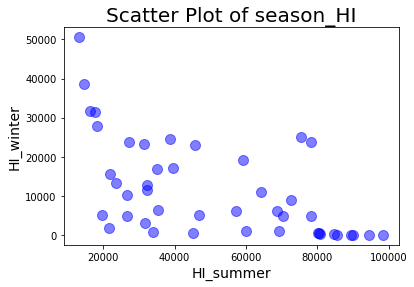

In [126]:
plt.plot('HI_summer',  # x
         'HI_winter',  # y
         data=season_HI,
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='blue', 
         alpha=0.5)

plt.title('Scatter Plot of season_HI', fontsize=20)
plt.xlabel('HI_summer', fontsize=14)
plt.ylabel('HI_winter', fontsize=14)

plt.show()

#### ④. 생성한 데이터프레임으로 상관계수 히트맵을 그림

<AxesSubplot:>

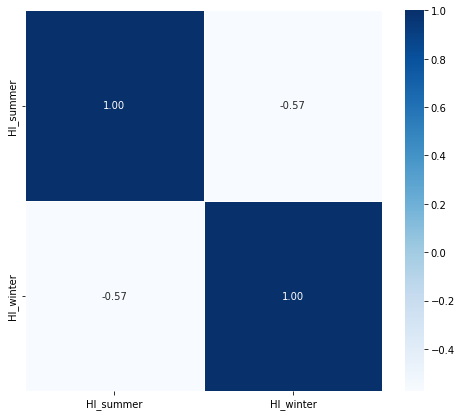

In [127]:
plt.figure(figsize=(8,7))
sns.heatmap(data=season_HI.corr(),annot=True,fmt='.2f',linewidths=.5,cmap='Blues')

-------------------
**결론**
* 겨울에 한파인 시간과 여름에 폭염인 시간은 대체로 반비례하는 관계
-------------------